<a href="https://colab.research.google.com/github/chugmn/NYP107Assign/blob/main/penwatch_yolo_success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using YOLO

 In this lab, we are going to learn how to train a pen and watch detector!

At the end of this exercise, you will be able to:

- create an object detection dataset in YOLO format
- fine-tune a YOLOv8 pretrained model with the custom dataset
- monitor the training progress and evaluation metrics
- deploy the trained model for object detection

## Create an object detection dataset

We will use a sample pen and watch dataset to illustrate the process of annotation and packaging the dataset into different format for object detection (e.g. YOLO, Pascal VOC, COCO, etc).

To annotate, there are many different tools available, such as the very basic [LabelImg](https://github.com/HumanSignal/labelImg) , or the more feature-packed tool such as [Label Studio](https://labelstud.io/), or online service such as [Roboflow](https://roboflow.com/).

### Raw Image Dataset

You can download the pen and watch images (without annotations) from this link:

https://github.com/chugmn/NYP107Assign/raw/refs/heads/main/penorwatches.v2i.yolov8.zip

Unzip the file to a local folder.

There are total of 74 images. You should divide the images into both training and validation set (e.g. 80%-20%, i.e. 59 images for train, and 15 for test).


### Option 1: Label Studio

You can follow the [steps](https://labelstud.io/guide/quick_start) here to setup Label Studio on your PC. It is recommended to setup a conda environment before you install the Label Studio.  

Here are the steps that need to be done:
1. Create a new Project
2. Import the images into Label Studio
3. Set up the Labelling UI tempalte (choose Object Detection with Bounding Box template)
4. Export the dataset in YOLO format.

The exported dataset will have the following folder structure:
```
<root folder>
classes.txt    --> contains the labels, with each class label on a new line
--images --> contains the images
--labels --> contains the annotations (i.e. bbox coordinates)
notes.json --> some info about this dataset (i.e. not used)
```

For training with YOLOv8 (from Ultralytics), you need to organize the files into `train` and `validate` (and optionally `test`) folders, and to create a `data.yaml` file to provide information about the folder location of test and validation set:

```
<root folder>
--train
----images
----labels
--valid
----images
----labels
data.yaml
```

The data.yaml file should specify the following:
```
train: ../train/images
val: ../valid/images
test: ../test/images

names:
    0: pen and watch
```

If you have more than one class of object to detect, specify the rest of the names under the names field.


## Option 2: Roboflow

Alternatively, you can use the online service Roboflow to do annotation. Roboflow integrates very well with Ultralytics and you can easily export the dataset in a format recognized by Ultralytics trainer (for YOLO model)

You can create a new account with [Roboflow](https://roboflow.com/).

Similarly, you can create a new project, upload all the raw images, annotate them and then export.

You can choose the format to be YOLOv8 and choose local directory to download the dataset locally instead of pushing it to the Roboflow universal wish.

Here is a [introductory blog](https://blog.roboflow.com/getting-started-with-roboflow/) on using the Roboflow to annotate.





## Auto Labelling using Grounding DINO

Both Label Studio and Roboflow supports the use of Grounding DINO to auto label the dataset.

[Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is open-set object detector, marrying Transformer-based detector DINO with grounded pre-training, which can detect arbitrary objects with human inputs (prompts) such as category names or referring expressions.

### Using Grounding DINO with Label Studio

You can follow the instruction [here](https://labelstud.io/blog/using-text-prompts-for-image-annotation-with-grounding-dino-and-label-studio/)  to setup the Grounding DINO ML backend to integrate with your label studio.

### Using Grounding DINO with Roboflow

Here is a [video tutorial](https://youtu.be/SDV6Gz0suAk) on using Grounding DINO with Roboflow.


### Download Annotated Dataset


We download and unzip to the directory called `datasets`



In [ ]:
%%capture
%%bash
wget https://github.com/chugmn/NYP107Assign/raw/refs/heads/main/penorwatches.v2i.yolov8.zip
mkdir -p datasets
unzip penorwatches.v2i.yolov8.zip -d datasets/

In [ ]:
%%capture
!pip install ultralytics
!pip install comet_ml

## Training the Model

YOLOv8 comes with different sizes of pretrained models: yolov8n, yolov8s, .... They differs in terms of their sizes, inference speeds and mean average precision:

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/yolo-models.png?raw=true" width="70%"/>


We will use the small pretrained model yolo8s and finetune it on our custom dataset.


### Setup the logging

Ultralytics support logging to `wandb`, `comet.ml` and `tensorboard`, out of the box. Here we only enable wandb.

You need to create an account at [`wandb`](https://wandb.ai) and get the API key from https://wandb.ai/authorize.


In [ ]:
from ultralytics import settings

settings.update({"wandb": True,
                 "comet": False,
                 "tensorboard": False})

### Training

We specify the path to `data.yaml` file, and train with a batch size of 15, and we also save the checkpoint at each epoch (save_period=1). We assume here you are connected to a GPU, hence we can specify the device to use as `device=0` to select the first GPU.  We specify the project name as 'penandwatch', this will create a folder called `penandwatch` to store the weights and various training artifacts such as F1, PR curves, confusion matrics, training results (loss, mAP, etc).

For a complete listing of train settings, you can see [here](https://docs.ultralytics.com/modes/train/#train-settings).

You can also specify the type of data [augmentation](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters)  you want as part of the train pipeline.

You can monitor your training progress at wandb (the link is given in the train output below)


In [ ]:
!ls -la datasets/valid/images | wc -l

12


In [ ]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolov8s.pt")  # Load a pre-trained YOLO model
result = model.train(data="datasets/data.yaml",
                     epochs=30,
                     save_period=1,
                     batch=16,
                     device="cpu",
                     project='pensandwatches',
                     plots=True)

100%|██████████| 21.5M/21.5M [00:00<00:00, 381MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cpu, workers=8, project=pensandwatches, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 83.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 38


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 38


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/train/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 1211.06it/s]

train: New cache created: /content/datasets/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 45. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/valid/labels... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 3235.79it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to pensandwatches/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to pensandwatches/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.897      4.536      2.133         31        640: 100%|██████████| 2/2 [01:24<00:00, 42.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]

                   all          9         15      0.315     0.0714      0.082     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G       1.54      3.382      1.772         44        640: 100%|██████████| 2/2 [01:18<00:00, 39.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]

                   all          9         15      0.167     0.0714     0.0952     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.441      2.774      1.795         32        640: 100%|██████████| 2/2 [01:20<00:00, 40.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]

                   all          9         15      0.386     0.0714      0.113     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.172      2.103      1.556         48        640: 100%|██████████| 2/2 [01:15<00:00, 37.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]

                   all          9         15     0.0708      0.812       0.13     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G       1.33      2.172      1.697         32        640: 100%|██████████| 2/2 [01:14<00:00, 37.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]

                   all          9         15      0.275      0.169      0.219       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.228      2.012       1.58         41        640: 100%|██████████| 2/2 [01:12<00:00, 36.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.66s/it]

                   all          9         15       0.51      0.205       0.19      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.085       1.56      1.424         56        640: 100%|██████████| 2/2 [01:13<00:00, 36.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]

                   all          9         15      0.366      0.392      0.333      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.9156      1.545      1.391         43        640: 100%|██████████| 2/2 [01:13<00:00, 36.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]

                   all          9         15      0.398      0.322      0.317      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.119      1.798      1.513         43        640: 100%|██████████| 2/2 [01:14<00:00, 37.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.15s/it]

                   all          9         15      0.208      0.143       0.16      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.052      1.515      1.416         43        640: 100%|██████████| 2/2 [01:13<00:00, 36.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]

                   all          9         15      0.958      0.143       0.19      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.9939      1.399      1.347         62        640: 100%|██████████| 2/2 [01:11<00:00, 35.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

                   all          9         15      0.515      0.398      0.289      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.125       1.55      1.494         44        640: 100%|██████████| 2/2 [01:11<00:00, 35.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]

                   all          9         15      0.615      0.473      0.479      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.118      1.622       1.55         43        640: 100%|██████████| 2/2 [01:10<00:00, 35.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

                   all          9         15      0.727      0.458      0.458      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.048      1.343      1.428         44        640: 100%|██████████| 2/2 [01:08<00:00, 34.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]

                   all          9         15      0.675      0.394      0.389      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.029      1.369       1.38         49        640: 100%|██████████| 2/2 [01:08<00:00, 34.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]

                   all          9         15      0.688      0.402      0.375      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.012      1.328      1.374         53        640: 100%|██████████| 2/2 [01:07<00:00, 33.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]

                   all          9         15      0.837      0.392      0.416      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.9123      1.331      1.357         45        640: 100%|██████████| 2/2 [01:07<00:00, 33.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

                   all          9         15      0.624      0.464      0.472      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.093      1.345      1.502         38        640: 100%|██████████| 2/2 [01:08<00:00, 34.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.89s/it]

                   all          9         15      0.768      0.527      0.565      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      0.886      1.318      1.328         35        640: 100%|██████████| 2/2 [01:10<00:00, 35.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

                   all          9         15      0.748      0.527      0.595      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.9506       1.21      1.367         42        640: 100%|██████████| 2/2 [01:14<00:00, 37.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]

                   all          9         15      0.698      0.589       0.56      0.284


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.8365      1.329      1.329         19        640: 100%|██████████| 2/2 [01:08<00:00, 34.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]

                   all          9         15      0.738      0.518      0.542      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.9488      1.282      1.485         19        640: 100%|██████████| 2/2 [01:13<00:00, 36.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

                   all          9         15      0.841      0.451      0.544      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.8657      1.262      1.349         22        640: 100%|██████████| 2/2 [01:10<00:00, 35.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]

                   all          9         15      0.699      0.455      0.495      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.8553      1.098       1.45         20        640: 100%|██████████| 2/2 [01:10<00:00, 35.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]

                   all          9         15      0.699      0.455      0.479       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G     0.6476     0.9709       1.25         20        640: 100%|██████████| 2/2 [01:10<00:00, 35.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]

                   all          9         15      0.781      0.455      0.534      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G     0.6926     0.9522      1.213         18        640: 100%|██████████| 2/2 [01:11<00:00, 35.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.14s/it]

                   all          9         15      0.578      0.476      0.465      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.6418     0.9145      1.227         19        640: 100%|██████████| 2/2 [01:09<00:00, 34.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]

                   all          9         15       0.71      0.455      0.482      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.6691     0.9181      1.251         20        640: 100%|██████████| 2/2 [01:10<00:00, 35.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]

                   all          9         15       0.71      0.455      0.482      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      0.585     0.9153      1.185         22        640: 100%|██████████| 2/2 [01:10<00:00, 35.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]

                   all          9         15      0.779      0.455      0.552      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.5545     0.8752      1.168         20        640: 100%|██████████| 2/2 [01:10<00:00, 35.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

                   all          9         15      0.657      0.507      0.502      0.263



30 epochs completed in 0.673 hours.
Optimizer stripped from pensandwatches/train/weights/last.pt, 22.5MB
Optimizer stripped from pensandwatches/train/weights/best.pt, 22.5MB

Validating pensandwatches/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


                   all          9         15      0.739      0.518      0.542      0.361
                   pen          7          7      0.739       0.41      0.391      0.292
                 watch          8          8      0.739      0.625      0.692      0.429
Speed: 2.5ms preprocess, 802.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to pensandwatches/train


lr/pg0,▁▂▃▄▄▅▆▆▆▇▇████████▇▇▇▆▆▅▅▄▃▃▂
lr/pg1,▁▂▃▄▄▅▆▆▆▇▇████████▇▇▇▆▆▅▅▄▃▃▂
lr/pg2,▁▂▃▄▄▅▆▆▆▇▇████████▇▇▇▆▆▅▅▄▃▃▂
metrics/mAP50(B),▁▁▁▂▃▂▄▄▂▂▄▆▆▅▅▆▆███▇▇▇▆▇▆▆▆▇▇
metrics/mAP50-95(B),▁▁▂▂▃▂▄▄▃▃▄▆▆▆▅▆▆▆▇▆█▇▆▆▅▅▅▅▆█
metrics/precision(B),▃▂▃▁▃▄▃▄▂█▅▅▆▆▆▇▅▇▆▆▆▇▆▆▇▅▆▆▇▆
metrics/recall(B),▁▁▁█▂▂▄▃▂▂▄▅▅▄▄▄▅▅▅▆▅▅▅▅▅▅▅▅▅▅
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▄▅▅▄▃▄▄▃▄▄▄▃▃▃▄▃▃▂▃▃▃▁▂▁▂▁▁


You can see the various graphs in your wandb dashboard, for example:

*metrics*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-metrics.png?raw=true"/>

*Train and validation loss*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-loss.png?raw=true"/>

You can go to the folder `penandwatch-->train-->weights` and you will files like epoch0.pt, epoch1.pt, .... and also best.pt.
The epoch0.pt, epoch1.pt are the checkpoints that are saved every period (in our case, we specify period as 1 epoch).  The best.pt contains the best checkpoint.

We can run the best model (using the best checkpoint) against the validation dataset to see the overall model performance on validation set.  

You should see around `0.88` for `mAP50`, and `0.78` for `mAP50-95`.

In [ ]:
from ultralytics import YOLO

model = YOLO("pensandwatches/train/weights/best.pt")
validation_results = model.val(data="datasets/data.yaml", device="cpu")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


                   all          9         15      0.739      0.518      0.542      0.361
                   pen          7          7      0.739       0.41      0.391      0.292
                 watch          8          8      0.739      0.625      0.692      0.429
Speed: 2.6ms preprocess, 771.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val


## Export and Deployment

Your model is in pytorch format (.pt). You can export the model to various format, e.g. TorchScript, ONNX, OpenVINO, TensorRT, etc. depending on your use case, and deployment platform (e.g. CPU or GPU, etc)

You can see the list of [supported formats](https://docs.ultralytics.com/modes/export/#export-formats)  and the option they support in terms of further optimization (such as imagesize, int8, half-precision, etc) in the ultralytics site.

Ultralytics provide a utility function to benchmark your model using different supported formats automatically. You can uncomment the code in the following code cell to see the benchmark result. If you are benchmarking for CPU only, the change the `device=0` to `device='cpu'`.  

**Beware: it will take quite a while to complete the benchmark**

In [ ]:
# from ultralytics.utils.benchmarks import benchmark

# # Benchmark on GPU (device=0 means the 1st GPU device)
# benchmark(model="penandwatch/train/weights/best.pt", data="datasets/data.yaml", imgsz=640, half=False, device=0)


In the following code, we export it as OpenVINO. OpenVINO is optimized for inference on Intel CPUs and since we will use the model later on to do inference on local Windows machine (which runs Intel chip), we will export it as OpenVINO format. We also specify using int8 quantization, which results in faster inference, at the cost of accuracy.

For more information on OpenVINO, go to the [official documentation](https://docs.openvino.ai/2024/index.html).

After export, you can find the openvino model in `penandwatch\train\weights\best_openvino_model` directory.

In [ ]:
model = YOLO("pensandwatches/train/weights/best.pt")
exported_path = model.export(format="openvino", int8=True)

Statistics collection ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━  75% 3/4 • 0:00:04 • 0:00:02

Output()

OpenVINO: export success ✅ 51.3s, saved as 'pensandwatches/train/weights/best_int8_openvino_model/' (11.2 MB)

Export complete (53.6s)
Results saved to /content/pensandwatches/train/weights
Predict:         yolo predict task=detect model=pensandwatches/train/weights/best_int8_openvino_model imgsz=640 int8 
Validate:        yolo val task=detect model=pensandwatches/train/weights/best_int8_openvino_model imgsz=640 data=datasets/data.yaml int8 
Visualize:       https://netron.app


## Inference

Let's test our model on some sample pictures. You can optionally specify the confidence threshold (e.g. `conf=0.5`), and the IoU (e.g. `iou=0.6`) for the NMS. The model will only output the bounding boxes of those detection that exceeds the confidence threshould and the IoU threshold.  

Image downloaded successfully!
Image loaded successfully!


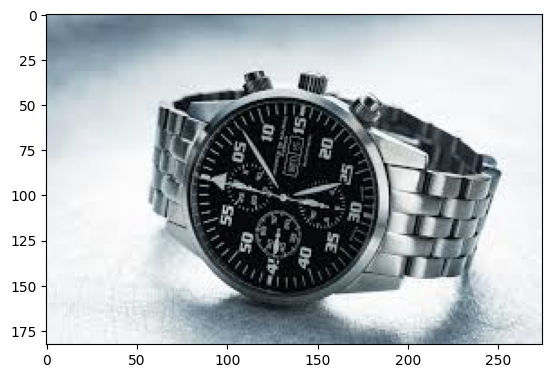

Loading pensandwatches/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

Found https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg locally at watchtest.jpeg
image 1/1 /content/watchtest.jpeg: 640x640 1 watch, 518.1ms
Speed: 14.7ms preprocess, 518.1ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)
Loading pensandwatches/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

Found https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg locally at watchtest.jpeg
image 1/1 /content/watchtest.jpeg: 640x640 1 watch, 559.6ms
Speed: 13.1ms preprocess, 559.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'pen', 1: 'watch'}
obb: None
orig_img: a

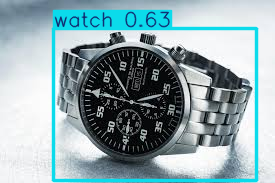

Image loaded successfully!


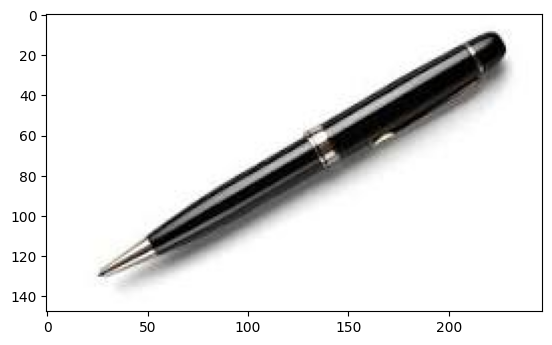

Loading pensandwatches/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

Found https://raw.githubusercontent.com/chugmn/NYP107Assign/main/pentest.jpeg locally at pentest.jpeg
image 1/1 /content/pentest.jpeg: 640x640 1 pen, 331.0ms
Speed: 11.8ms preprocess, 331.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'pen', 1: 'watch'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...

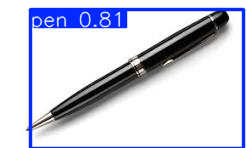

In [ ]:
#---
import requests
from PIL import Image
from io import BytesIO

# Image URL
url = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg'

# Fetch the image
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    print("Image downloaded successfully!")
    # Open the image with PIL to check if it works
    img = Image.open(BytesIO(response.content))
    img.show()
else:
    print("Failed to download image. Status code:", response.status_code)


#---
import cv2
import requests
import numpy as np

# Path where the image is saved
image_path = '/content/watchtest.jpeg'

# Download the image
url = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg'
img_data = requests.get(url).content
with open(image_path, 'wb') as f:
    f.write(img_data)

# Read the image using OpenCV
img = cv2.imread(image_path)

if img is None:
    print("Image not read correctly!")
else:
    print("Image loaded successfully!")

# Show the image (optional)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#

import ultralytics
from ultralytics import YOLO
from PIL import Image

#source = 'https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/sample_penandwatch.jpeg'
#source = './samples/sample_penandwatch.jpeg'
source = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg'
model = YOLO("pensandwatches/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)
model = YOLO("pensandwatches/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)
# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")




  # Pen detection


import cv2
import requests
import numpy as np

# Path where the image is saved
image_path = '/content/pentest.jpeg'

# Download the image
url = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/pentest.jpeg'
img_data = requests.get(url).content
with open(image_path, 'wb') as f:
    f.write(img_data)

# Read the image using OpenCV
img = cv2.imread(image_path)

if img is None:
    print("Image not read correctly!")
else:
    print("Image loaded successfully!")

# Show the image (optional)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#

import ultralytics
from ultralytics import YOLO
from PIL import Image

#source = 'https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/sample_balloon.jpeg'
#source = './samples/sample_penanwatch.jpeg'
source = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/pentest.jpeg'
model = YOLO("pensandwatches/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)

# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

## Download the Model

If you are training your model on Google Colab, you will download the exported OpenVINO model to a local PC. If you are training your model locally, then the exported model should already be on your local PC.

Run the following code to zip up the OpenVINO folder and download to local PC.

*Note: If you encountered error message "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968", uncomment the following cell and run it.*


In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%bash
mv ./pensandwatches/train/weights/best_int8_openvino_model/ .
zip -r best_int8_openvino_model.zip best_int8_openvino_model

# Now go to best_openvino_model to download the best_openvino_model.zip file

  adding: best_int8_openvino_model/ (stored 0%)
  adding: best_int8_openvino_model/best.xml (deflated 95%)
  adding: best_int8_openvino_model/best.bin (deflated 18%)
  adding: best_int8_openvino_model/metadata.yaml (deflated 31%)


## Streaming

We can also do real-time detection on a video or camera steram.

The code below uses openCV library to display video in a window, and can only be run locally on a local laptop.




### Video File

You need `OpenCV` to run the following code.  In your conda environment, install `opencv` for python using the following command:

```
pip3 install opencv-python
```
or
```
conda install opencv
```

Let's donwload the sample video file.

In [ ]:
!wget https://githubusercontent.com/chugmn/NYP107Assign/raw/refs/heads/main/penwatch.mp4

--2024-12-29 08:18:39--  https://githubusercontent.com/chugmn/NYP107Assign/raw/refs/heads/main/penwatch.mp4
Resolving githubusercontent.com (githubusercontent.com)... failed: No address associated with hostname.
wget: unable to resolve host address ‘githubusercontent.com’


### Streaming and display video

### Detect and write to a video file

In [1]:
# Install required libraries
# Install Gradio for the interface
!pip install gradio

# Install ultralytics for YOLO model handling
!pip install ultralytics

# Install OpenCV for video processing
!pip install opencv-python-headless

# Install Pillow for image handling
!pip install pillow

# Install huggingface-hub for Hugging Face integrations
!pip install huggingface-hub

# Install openvino for YOLO OpenVINO inference
!pip install openvino

# Install ffmpeg-python for handling video streams
!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 20.3 MB/s eta 0:00:00


In [4]:
import gradio as gr  # Gradio for building the web interface
from ultralytics import YOLO  # YOLO model for object detection
from PIL import Image  # PIL for image processing
import os  # OS module for file operations
import cv2  # OpenCV for video processing
import tempfile  # Temporary file creation
import threading  # For managing video processing threads

# Constants for student details
STUDENT_ID = "1204756F"
STUDENT_NAME = "Mohandas Vishindas Chugani"

# Load the pre-trained YOLO model
MODEL_PATH = "best_int8_openvino_model.zip"  # Path to your trained YOLO model
model = YOLO(MODEL_PATH, task="detect")  # Initialize the detection model

# Define fixed dimensions for consistent display of input/output
image_height = 300  # Height of the image display
image_width = 400  # Width of the image display
video_height = 300  # Height of the video display
video_width = 400  # Width of the video display

# Global flag for stopping video processing
stop_video_processing = threading.Event()

# Function to process an uploaded image
def process_image(image):
    results = model.predict(source=image, conf=0.5)  # Perform inference with confidence threshold
    result_img = results[0].plot()  # Plot the detection results on the image
    return Image.fromarray(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))  # Convert to RGB for consistency

# Function to reset the image input and output
def reset_image():
    return None, None  # Reset both input and output to None

# Function to process an uploaded video
def process_video(video_path):
    stop_video_processing.clear()  # Clear the stop signal
    temp_dir = tempfile.mkdtemp()  # Create a temporary directory for the output video
    output_video_path = os.path.join(temp_dir, "processed_video.mp4")  # Path to save the processed video
    cap = cv2.VideoCapture(video_path)  # Open the video file
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Get the video frame width
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Get the video frame height
    fps = cap.get(cv2.CAP_PROP_FPS)  # Get the video frame rate

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Process each frame of the video
    while cap.isOpened():
        if stop_video_processing.is_set():  # Check if the stop signal is set
            break
        ret, frame = cap.read()  # Read a frame
        if not ret:  # Break the loop if no frame is read
            break
        results = model.predict(source=frame, conf=0.5)  # Perform inference on the frame
        result_frame = results[0].plot()  # Plot detection results on the frame
        result_frame_corrected = cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB)  # Correct the color format
        out.write(cv2.cvtColor(result_frame_corrected, cv2.COLOR_RGB2BGR))  # Write the frame to the output video

    cap.release()  # Release the video capture object
    out.release()  # Release the video writer object
    return output_video_path  # Return the path to the processed video

# Function to stop video processing
def stop_video():
    stop_video_processing.set()  # Set the stop signal

# Function to reset the video input and output
def reset_video():
    return None, None  # Reset both input and output to None

# Create the Gradio interface with tabs for image and video detection
with gr.Blocks() as app:
    gr.Markdown(
        """
        <h1 style="text-align: center; font-family: Arial, sans-serif; font-weight: bold; color: #2E86C1;">
            Pen and Watch Detection
        </h1>
        <p style="text-align: center; font-size: 18px; color: #555;">
            This app uses a trained YOLO model to detect objects such as pens and watches
            in images and videos. Created by <b>Mohandas Vishindas Chugani (ID: 1204756F)
        </p>
        """
    )

    with gr.Tabs():
        # Tab for image detection
        with gr.TabItem("🖼️ Image Detection"):
            with gr.Row():
                with gr.Column():
                    image_input = gr.Image(
                        type="pil", label="Input Image", elem_id="image_input",
                        width=image_width, height=image_height
                    )
                with gr.Column():
                    image_output = gr.Image(
                        type="pil", label="Output Image", elem_id="image_output",
                        width=image_width, height=image_height
                    )
            image_submit = gr.Button("Detect Objects in Image")
            image_reset = gr.Button("Reset")
            image_submit.click(process_image, inputs=image_input, outputs=image_output)
            image_reset.click(reset_image, inputs=[], outputs=[image_input, image_output])

        # Tab for video detection
        with gr.TabItem("🎥 Video Detection"):
            with gr.Row():
                with gr.Column():
                    video_input = gr.Video(
                        label="Input Video", elem_id="video_input",
                        width=video_width, height=video_height
                    )
                with gr.Column():
                    video_output = gr.Video(
                        label="Output Video", elem_id="video_output",
                        width=video_width, height=video_height
                    )
                    video_stop = gr.Button("Stop Processing")  # Place below the output video
            video_submit = gr.Button("Detect Objects in Video")
            video_reset = gr.Button("Reset")
            video_submit.click(process_video, inputs=video_input, outputs=video_output)
            video_stop.click(stop_video)
            video_reset.click(reset_video, inputs=[], outputs=[video_input, video_output])

app.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0231634aaf134f3018.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
